# Sentiment Analysis with SBERT embeddings

## Our Dataset

This dataset describes the contents of the heart-disease diagnosis.

The dataset in this study is from [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data), which is called Twitter US Airline Sentiment.

- Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data

## Variable Table

| Original Dataset             | Data Type     | Description    |                                                         
|------------------------------|---------------|---------------------------------------------------------------------------------------------|
| tweet_id                     | ID            | A unique identifier for each tweet.                                                         | 
| airline_sentiment            | Categorical   | The sentiment expressed in the tweet (positive, neutral, negative).                         | 
| airline_sentiment_confidence | Numerical     | Confidence score in the sentiment label (0 to 1).                                           | 
| negativereason               | Categorical   | Reason for negative sentiment (e.g., "Late Flight", "Customer Service Issue").              | 
| negativereason_confidence    | Numerical     | Confidence score in the negative reason label (0 to 1).                                     | 
| airline                      | Categorical   | The airline mentioned in the tweet (e.g., United, Delta, etc.).                             | 
| airline_sentiment_gold       | Categorical   | Sentiment label by trusted annotator (gold standard).                                       | 
| name                         | Text          | Name of the user who posted the tweet.                                                      | 
| negativereason_gold          | Categorical   | Negative reason label by trusted annotator (gold standard).                                 | 
| retweet_count                | Numerical     | Number of times the tweet was retweeted.                                                    | 
| text                         | Text          | The full content of the tweet.                                                              | 
| tweet_coord                  | Geospatial    | Latitude and longitude coordinates where the tweet was posted, if available.                | 
| tweet_created                | Datetime      | Timestamp when the tweet was created.                                                       | 
| tweet_location               | Text          | Location specified in the user's profile.                                                   | 
| user_timezone                | Categorical   | Time zone specified in the user's profile.                                                  | 

<br/>

## Data Used for Modeling

| Feature                      | Data Type   | Description  |
|-----------------------------|-------------|--------------|
| **Target Variable: `encoded_sentiment`** | Categorical | This is an engineered variable derived from `airline_sentiment` for multi-class sentiment classification. It encodes sentiment as: 0 = Negative, 1 = Neutral, 2 = Positive. |
| **Feature: `text`**         | Text        | Contains consumer tweets about U.S. airlines. This field undergoes preprocessing, including removal of URLs and mentions (`@`), and stopword removal |


<br/>

# 1. Load Data

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../../data/tweets.csv.gz", compression="gzip")

In [2]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [3]:
# Show the first few rows
df.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)

# 2. Data Preprocessing

## 2.1 Handle Duplicates

In [4]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Drop duplicate rows
df.drop_duplicates(inplace=True)

Number of duplicate rows: 36


In [5]:
# Confirm the shape after removal
print(f"Shape after dropping duplicates: {df.shape}")

Shape after dropping duplicates: (14604, 15)


## 2.2 Handle Missing Values

In [6]:
# Check for missing values for each variables in the dataset
print("\nMissing values count for each variables:")
print("-------------------------------------------")
print(df.isnull().sum())

print("""\n\n**Note**: We won't remove any rows with missing values here as 
our main field we use is 'text' and 'airline_sentiment' column,
which has no missing values""")


Missing values count for each variables:
-------------------------------------------
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64


**Note**: We won't remove any rows with missing values here as 
our main field we use is 'text' and 'airline_sentiment' column,
which has no missing values


## 2.3 Text Processing

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2.3.1 Feature Engineering

For feature engineering in sentiment analysis, we will perform the following steps:

- `Stopwords Removal`: Eliminating common words (e.g., "the", "is", "and") that don't contribute meaningful information.

In [8]:
import re

# Initialize stopwords, stemmer
stop_words = set(stopwords.words('english'))

# Step 1: Lowercase and clean the text
def clean_text(text):
    text = text.lower()                                 # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text)                    # Remove mentions
    # text = re.sub(r'#\w+', '', text)                    # NOTE: Do not remove hashtags, 
                                                                # as there is a lot of hashtags with sentiment indication, 
                                                                # such as '#thankyou', '#happycustomer', etc...
    # text = re.sub(r'[^a-z\s]', '', text)                # NOTE: no need to remove numbers and punctuation for sbert embedding
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Copy only the 'text' column to df_copy
df2 = df[['text', 'airline_sentiment']].copy()

# processed text after rule-based removing URL, twitter username
df2['clean_text'] = df2['text'].apply(clean_text)


In [9]:
df2.shape

(14604, 3)

In [10]:
# Check for missing values per column
print("\nMissing values per column:")
print(df2.isnull().sum())


Missing values per column:
text                 0
airline_sentiment    0
clean_text           0
dtype: int64


### 2.3.2 Target Engineering

We will convert the 'airline_sentiment' column into numerical values to use it as the target variable in our model, where `negative` = 0, `neutral` = 1, and `positive` = 2 

In [11]:
print("The target variable contains unique values of: ", df2['airline_sentiment'].unique(), 
      "which we are going to map it into 0, 1 and 2 respectively")

# Encode the sentiment column
df2['encoded_sentiment'] = df2['airline_sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})


The target variable contains unique values of:  ['neutral' 'positive' 'negative'] which we are going to map it into 0, 1 and 2 respectively


## 3.0 Data Preparation for Modeling

In [12]:
df2

text airline_sentiment  \
0                    @VirginAmerica What @dhepburn said.           neutral   
1      @VirginAmerica plus you've added commercials t...          positive   
2      @VirginAmerica I didn't today... Must mean I n...           neutral   
3      @VirginAmerica it's really aggressive to blast...          negative   
4      @VirginAmerica and it's a really big bad thing...          negative   
...                                                  ...               ...   
14635  @AmericanAir thank you we got on a different f...          positive   
14636  @AmericanAir leaving over 20 minutes Late Flig...          negative   
14637  @AmericanAir Please bring American Airlines to...           neutral   
14638  @AmericanAir you have my money, you change my ...          negative   
14639  @AmericanAir we have 8 ppl so we need 2 know h...           neutral   

                                              clean_text  encoded_sentiment  
0                                             what said.                  1  
1      plus you've added commercials to the experienc...                  2  
2      i didn't today... must mean i need to take ano...                  1  
3      it's really aggressive to blast obnoxious "ent...                  0  
4               and it's a really big bad thing about it                  0  
...                                                  ...                ...  
14635  thank you we got on a different flight to chic...                  2  
14636  leaving over 20 minutes late flight. no warnin...                  0  
14637    please bring american airlines to #blackberry10                  1  
14638  you have my money, you change my flight, and d...                  0  
14639  we have 8 ppl so we need 2 know how many seats...                  1  

[14604 rows x 4 columns]

In [13]:
# Split into features (X) and target labels (y)
X = df2['clean_text']
y = df2['encoded_sentiment']

### 3.1 Train test split with stratified sampling

In [14]:
from sklearn.model_selection import train_test_split

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        stratify=y,            
                                        test_size=0.2, 
                                        # use random_state parameter to make sure it results in consistent output when performing train test split
                                        random_state=42)

In [15]:
# Export train and test dataset to `data` folder
pd.concat([X_train, y_train], axis=1).to_csv("../../data/train.csv.gz", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../../data/test.csv.gz", index=False)

In [16]:
# Verify that class distribution is preserved after the train-test split (i.e., stratified correctly)

print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

print("""\n**Observation**: The class proportions appear to be preserved across the training and test sets, 
indicating a successful stratified split.""")

Train class distribution:
encoded_sentiment
0    0.627151
1    0.211675
2    0.161174
Name: proportion, dtype: float64

Test class distribution:
encoded_sentiment
0    0.627182
1    0.211571
2    0.161246
Name: proportion, dtype: float64

**Observation**: The class proportions appear to be preserved across the training and test sets, 
indicating a successful stratified split.


### 3.2 Text Representation with SBERT embedding

In [17]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer

EMBEDDING_TRAIN = "../../data/sbert_embedding_train.csv.gz"

if os.path.exists(EMBEDDING_TRAIN):
    X_train_sbert_embedding = pd.read_csv(EMBEDDING_TRAIN, compression="gzip")
else:
    # Load the SBERT model
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_train_sbert_embedding = sbert_model.encode(X_train.to_numpy(), show_progress_bar=True)

    # Save the sbert_embedding_train to `data` folder
    pd.DataFrame(X_train_sbert_embedding).to_csv(EMBEDDING_TRAIN, index=False)
    print(X_train_sbert_embedding)

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

[[ 0.0139826   0.1142958   0.08276999 ... -0.04016466 -0.02195244
  -0.01605946]
 [ 0.04317063  0.01765626  0.02410275 ...  0.00355387 -0.08676535
   0.01846397]
 [-0.04912351  0.02037614  0.08552862 ... -0.03908001 -0.07733253
   0.0187934 ]
 ...
 [ 0.0228613  -0.00909811  0.08430936 ... -0.01946218 -0.08206341
   0.00413905]
 [ 0.04167972  0.03650422  0.03250316 ...  0.01129464 -0.13246708
  -0.02560784]
 [ 0.01725893 -0.00468032 -0.05806556 ... -0.05446876 -0.10305684
   0.00600195]]


In [18]:
import pandas as pd

EMBEDDING_TEST = "../../data/sbert_embedding_test.csv.gz"
if os.path.exists(EMBEDDING_TEST):
    X_test_sbert_embedding = pd.read_csv(EMBEDDING_TEST, compression="gzip")
else:
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_test_sbert_embedding = sbert_model.encode(X_test.to_numpy(), show_progress_bar=True)

    # Save the sbert_embedding_test to `data` folder
    pd.DataFrame(X_test_sbert_embedding).to_csv(EMBEDDING_TEST, index=False)
    print(X_test_sbert_embedding)

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

[[-0.03903015 -0.06118567 -0.00021094 ... -0.00400127 -0.07471005
  -0.03602498]
 [-0.07696652  0.05375435  0.08196452 ... -0.11187609 -0.11145037
  -0.01333212]
 [ 0.04201006 -0.01954771  0.06486293 ... -0.07420429  0.00329494
  -0.004595  ]
 ...
 [-0.05767511 -0.00922443 -0.09565146 ... -0.02795863 -0.1333488
  -0.03106456]
 [ 0.03976385  0.00218878 -0.01505788 ...  0.02895043 -0.04057666
  -0.04590299]
 [-0.04591164  0.01408936  0.08073609 ... -0.03192811 -0.02009708
  -0.11772283]]


In [19]:
X_train_vectorized = pd.read_csv("../../data/sbert_embedding_train.csv.gz", compression="gzip")
X_test_vectorized = pd.read_csv("../../data/sbert_embedding_test.csv.gz", compression="gzip")

### 3.3 Handling class imbalance issue with SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

# Handling imbalanced using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [21]:
# Check class distribution before and after applying SMOTE to confirm successful balancing

print("Class distribution in training set (before SMOTE):")
print(y_train.value_counts())

print("\nClass distribution in training set (after SMOTE):")
print(y_train_resampled.value_counts())

print("""\n**Observation**: The class distribution in the training set has been balanced after applying SMOTE, 
confirming that oversampling was successful.""")


Class distribution in training set (before SMOTE):
encoded_sentiment
0    7327
1    2473
2    1883
Name: count, dtype: int64

Class distribution in training set (after SMOTE):
encoded_sentiment
0    7327
1    7327
2    7327
Name: count, dtype: int64

**Observation**: The class distribution in the training set has been balanced after applying SMOTE, 
confirming that oversampling was successful.


## 4.0 Modeling

(i) Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Predictions on training and test sets
y_train_pred_lr = model.predict(X_train_resampled)
y_test_pred_lr = model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train_resampled, y_train_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train_resampled, y_train_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train_resampled, y_train_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")
print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8314
Test Accuracy:  0.7799

Train F1-score: 0.8316
Test F1-score:  0.7880

Train Precision: 0.8318
Test Precision:  0.8090

Train Recall: 0.8314
Test Recall:  0.7799

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1832
           1       0.57      0.78      0.66       618
           2       0.70      0.73      0.72       471

    accuracy                           0.78      2921
   macro avg       0.73      0.77      0.74      2921
weighted avg       0.81      0.78      0.79      2921

Confusion Matrix (Test):
[[1452  283   97]
 [  88  481   49]
 [  42   84  345]]


(ii) Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)

# Train the model
dt_model.fit(X_train_resampled, y_train_resampled)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_resampled)
y_test_pred_dt = dt_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train_resampled, y_train_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train_resampled, y_train_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train_resampled, y_train_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")
print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.7156
Test Accuracy:  0.6299

Train F1-score: 0.7161
Test F1-score:  0.6458

Train Precision: 0.7170
Test Precision:  0.6801

Train Recall: 0.7156
Test Recall:  0.6299

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      1832
           1       0.40      0.58      0.47       618
           2       0.48      0.55      0.51       471

    accuracy                           0.63      2921
   macro avg       0.57      0.60      0.57      2921
weighted avg       0.68      0.63      0.65      2921

Confusion Matrix (Test):
[[1226  414  192]
 [ 170  357   91]
 [  84  130  257]]


(iii) XGBoost

In [24]:
import os
import joblib
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the XGBoost Classifier
model_path = "../../models/sbert_embedding_xgb_model.pkl"
if os.path.exists(model_path):
    print("Loading existing model...")
    xgb_model = joblib.load(model_path)
else:
    # Train the model
    xgb_model = xgb.XGBClassifier(max_depth=10,
                                random_state=42,
                                # Introduce randomness to make training faster and reduce overfitting
                                subsample=0.8, ## Uses 80% of the data for each tree.
                                colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                                # the parameters below make the model trained faster by enabling parallelism
                                n_jobs = -1)
    xgb_model.fit(X_train_resampled, y_train_resampled)
    # Export and load previously trained model to avoid retraining every time
    joblib.dump(xgb_model, model_path)
    print("Model saved.")

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_resampled)
y_test_pred_xgb = xgb_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train_resampled, y_train_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train_resampled, y_train_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train_resampled, y_train_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")
print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Loading existing model...
Train Accuracy: 0.9985
Test Accuracy:  0.8127

Train F1-score: 0.9985
Test F1-score:  0.8117

Train Precision: 0.9985
Test Precision:  0.8115

Train Recall: 0.9985
Test Recall:  0.8127

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1832
           1       0.66      0.67      0.66       618
           2       0.77      0.69      0.73       471

    accuracy                           0.81      2921
   macro avg       0.77      0.75      0.76      2921
weighted avg       0.81      0.81      0.81      2921

Confusion Matrix (Test):
[[1637  141   54]
 [ 162  412   44]
 [  74   72  325]]


## 5.0 Text Mining with Decision Tree plot and SHAP value analysis

### 5.1 Decision Tree Plot

Reference: https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-shap-values-2a0e34219177

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot decision tree
plt.figure(figsize=(200, 200))
plot_tree(dt_model, filled=True, max_depth=5, 
          feature_names=None, 
          class_names=["Negative", "Neutral", "Positive"])
plt.show()

### 5.2 SHAP value analysis on best model in this notebook

In [ ]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(xgb_model,
                           X_train_resampled, 
                           feature_names=None)

# Compute SHAP values for the test set
shap_values = explainer(X_test_vectorized)

print(shap_values.values.shape)


(2921, 384, 3)


- Feature importance with SHAP value analysis

Positive Sentiment


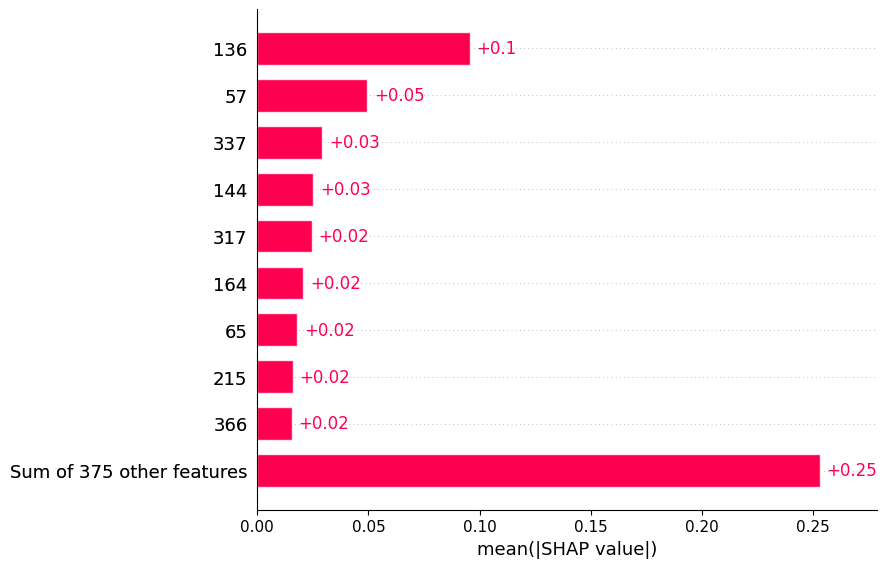

Neutral Sentiment


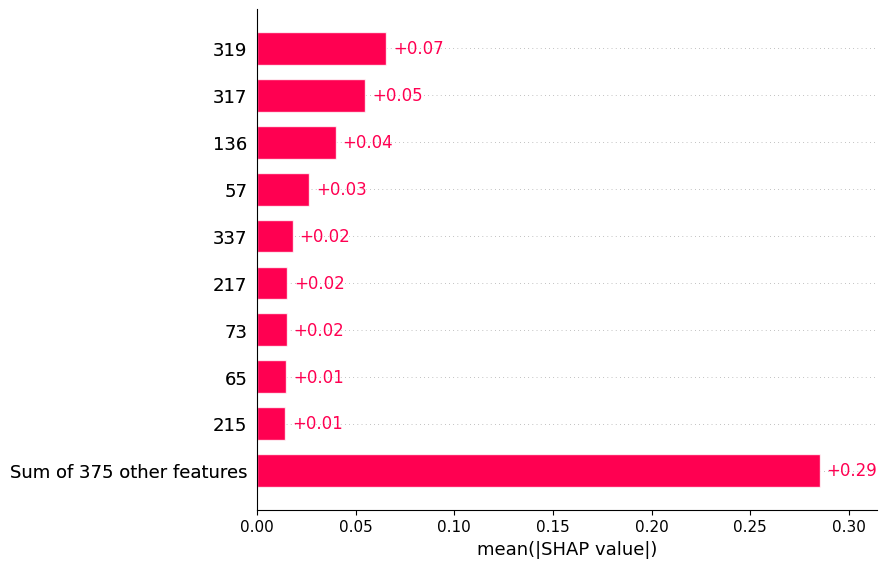

Negative Sentiment


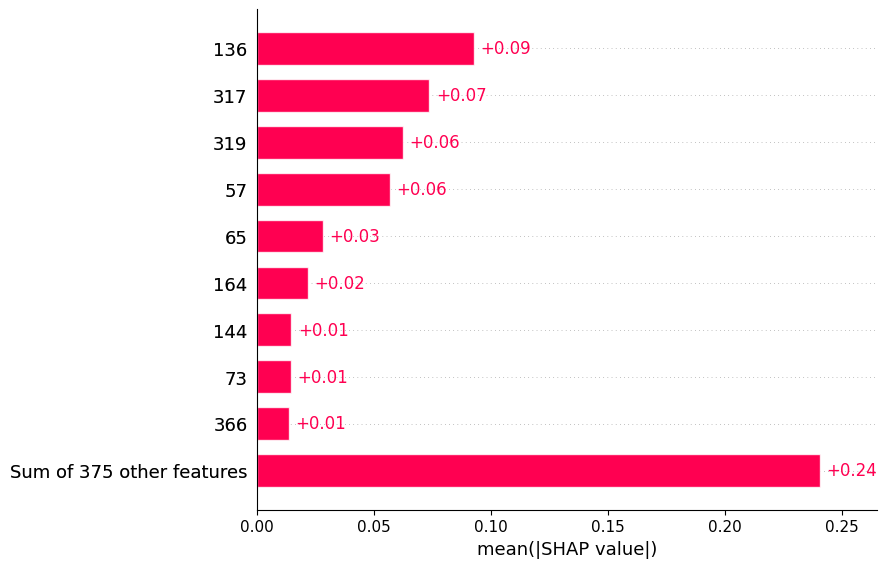

In [27]:
print("Positive Sentiment")
shap.plots.bar(shap_values[:,:,2])

print("Neutral Sentiment")
shap.plots.bar(shap_values[:,:,1])

print("Negative Sentiment")
shap.plots.bar(shap_values[:,:,0])

- SHAP value analysis for individual comments

Original text:  thanks for helping my mom after wouldn't let her get on her plane in orlando! you're the best! #customerservice
Processed text:  thanks for helping my mom after wouldn't let her get on her plane in orlando! you're the best! #customerservice
------------------------

The original sentiment of the 3-rd text item is Positive
The predicted sentiment of the 3-rd text item is Positive
------------------------



Probability of Negative Sentiment, f(x='Negative')


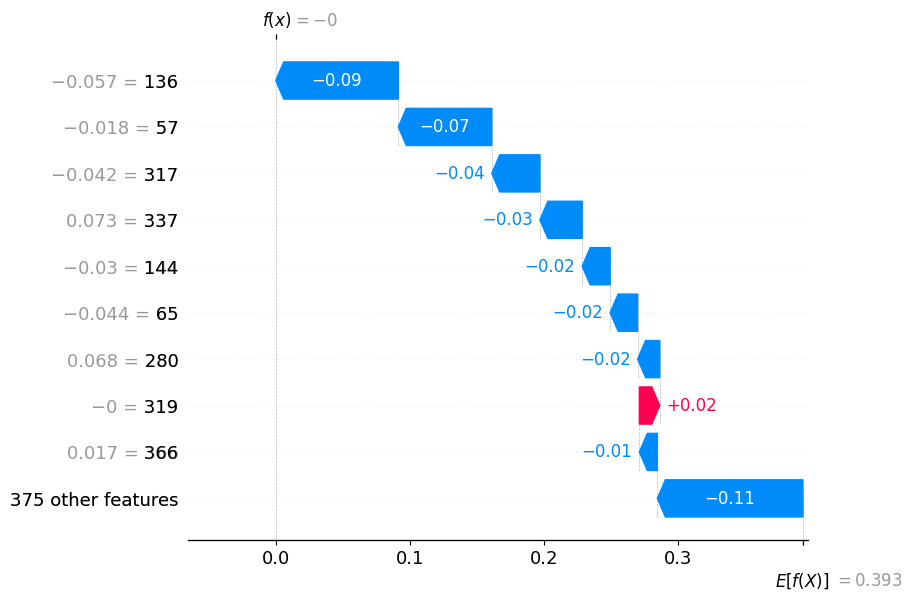

Probability of Neutral Sentiment, f(x='Neutral')


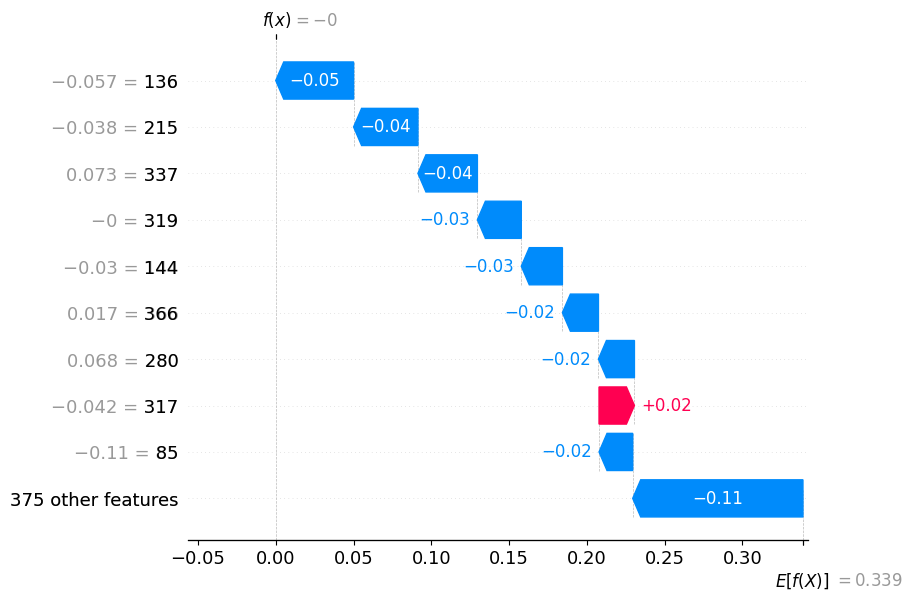

Probability of Positive Sentiment, f(x='Positive')


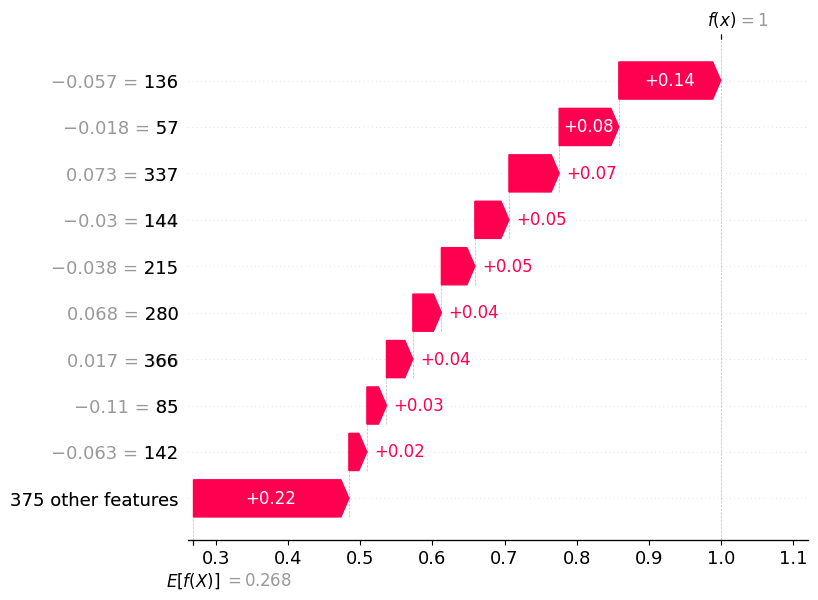

In [28]:
# SHAP value analysis for one of positive-sentiment comments
ind = 3

original_text = pd.read_csv("../../data/test.csv.gz", compression="gzip")["clean_text"].iloc[ind]
processed_text = X_test.iloc[ind]

print("Original text: ", original_text)
print("Processed text: ", processed_text)
print("------------------------\n")

print(f"The original sentiment of the {ind}-rd text item is",
      y_test.replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print(f"The predicted sentiment of the {ind}-rd text item is",
      pd.Series(y_test_pred_dt).replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print("------------------------\n")

shap.initjs()
print("Probability of Negative Sentiment, f(x='Negative')")
shap.plots.waterfall(shap_values[ind,:,0])

print("Probability of Neutral Sentiment, f(x='Neutral')")
shap.plots.waterfall(shap_values[ind,:,1])

print("Probability of Positive Sentiment, f(x='Positive')")
shap.plots.waterfall(shap_values[ind,:,2])

Original text:  will you be issuing an exception policy for denver for this weekend?
Processed text:  will you be issuing an exception policy for denver for this weekend?
------------------------

The original sentiment of the 2-th row of text item is Neutral
The predicted sentiment of the 2-th row of text item is Neutral
------------------------



Probability of Negative Sentiment, f(x='Negative')


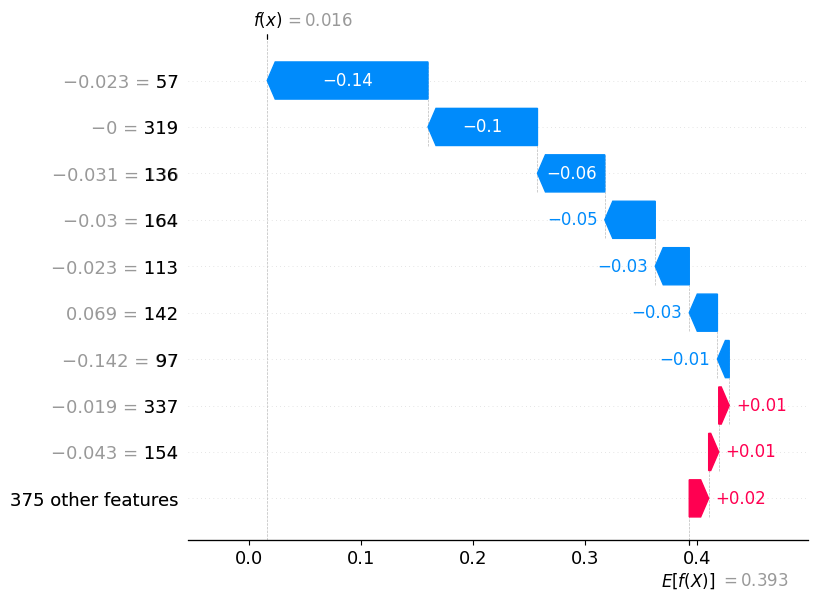

Probability of Neutral Sentiment, f(x='Neutral')


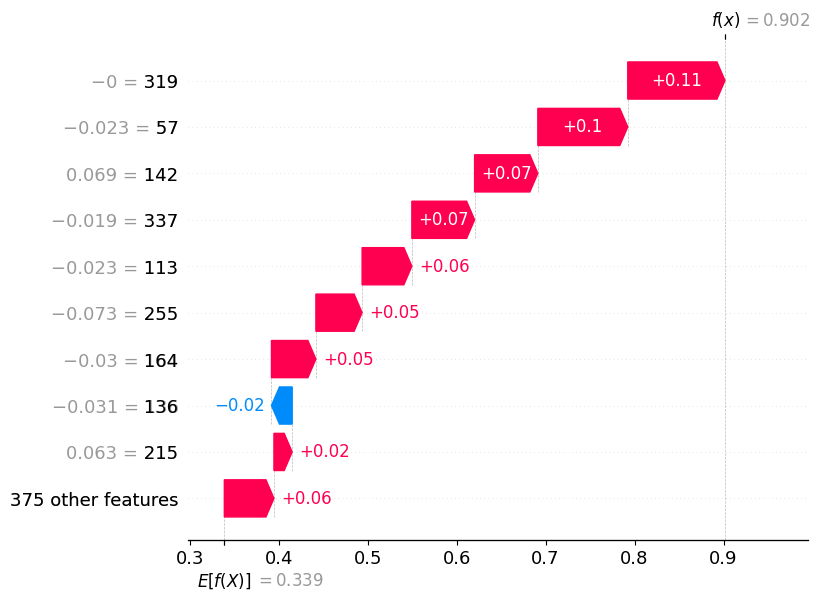

Probability of Positive Sentiment, f(x='Positive')


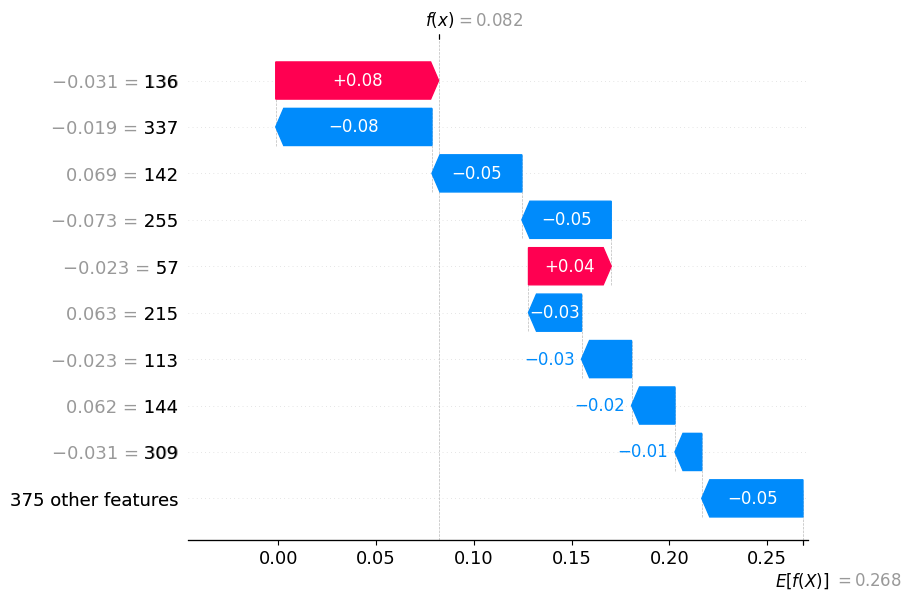

In [29]:
# Let’s do the same with a neutral review.

ind = 2

original_text = pd.read_csv("../../data/test.csv.gz", compression="gzip")["clean_text"].iloc[ind]
processed_text = X_test.iloc[ind]

print("Original text: ", original_text)
print("Processed text: ", processed_text)
print("------------------------\n")

print(f"The original sentiment of the {ind}-th row of text item is",
      y_test.replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print(f"The predicted sentiment of the {ind}-th row of text item is",
      pd.Series(y_test_pred_dt).replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print("------------------------\n")

shap.initjs()
print("Probability of Negative Sentiment, f(x='Negative')")
shap.plots.waterfall(shap_values[ind,:,0])

print("Probability of Neutral Sentiment, f(x='Neutral')")
shap.plots.waterfall(shap_values[ind,:,1])

print("Probability of Positive Sentiment, f(x='Positive')")
shap.plots.waterfall(shap_values[ind,:,2])

Original text:  me again! i was just trying to rebook fare on wanna get away pricing and it disappeared in time i refreshed. is this normal?
Processed text:  me again! i was just trying to rebook fare on wanna get away pricing and it disappeared in time i refreshed. is this normal?
------------------------

The original sentiment of the 9-th row of text item is Negative
The predicted sentiment of the 9-th row of text item is Negative
------------------------



Probability of Negative Sentiment, f(x='Negative')


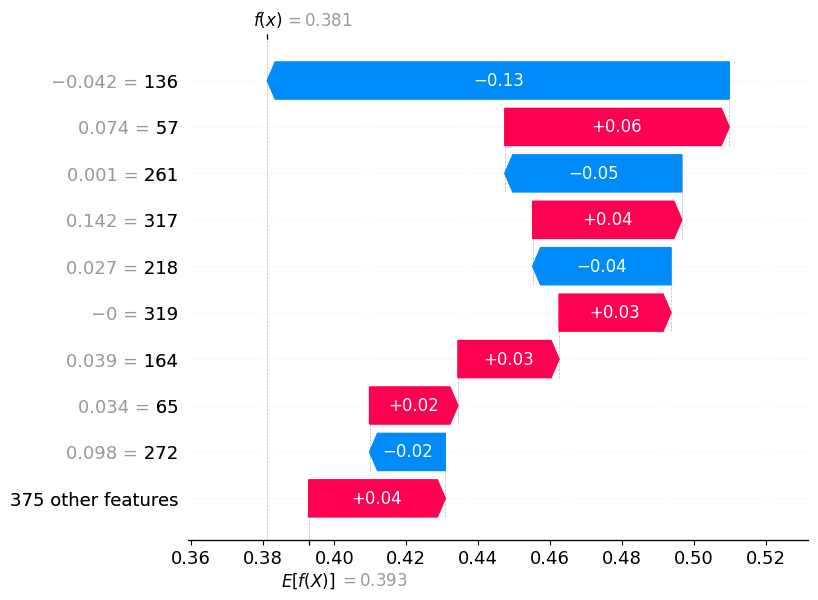

Probability of Neutral Sentiment, f(x='Neutral')


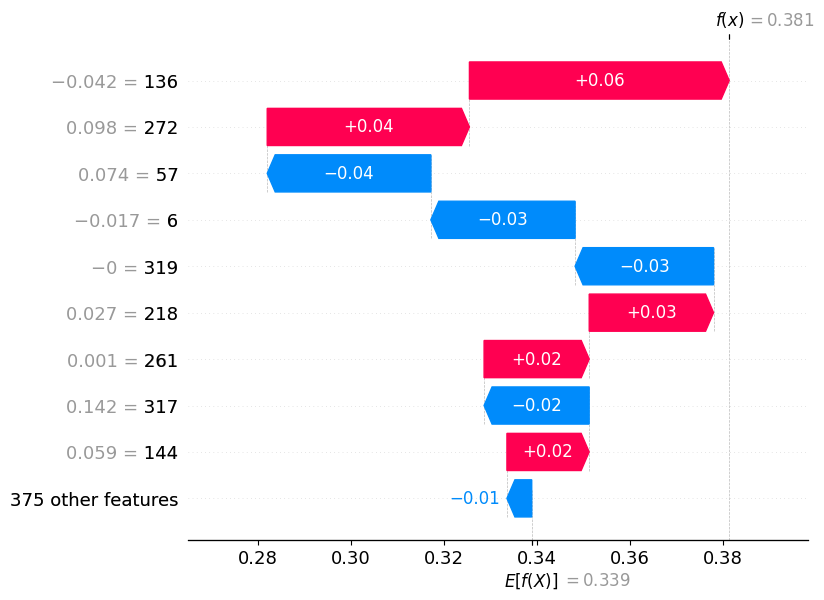

Probability of Positive Sentiment, f(x='Positive')


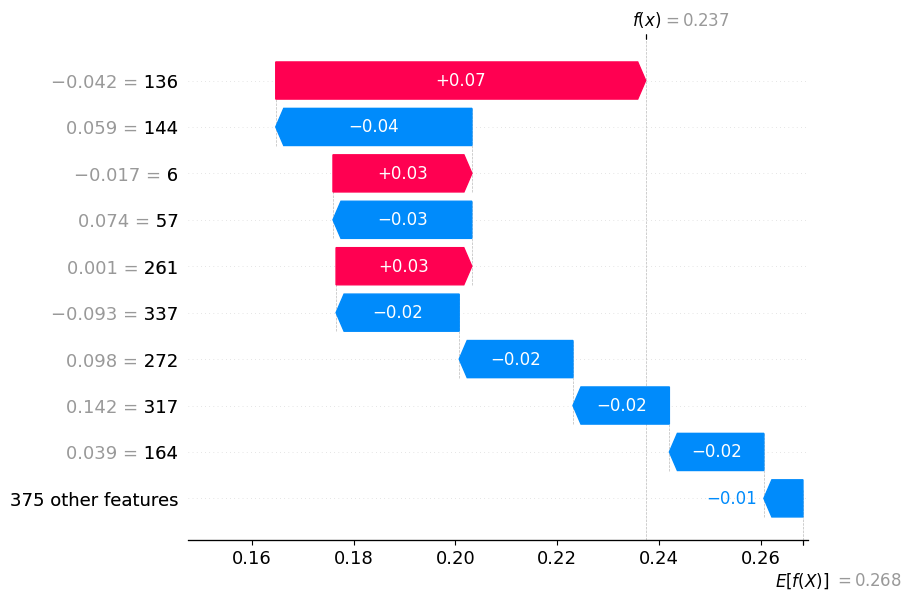

In [30]:
# Let’s do the same with a negative review.

ind = 9

original_text = pd.read_csv("../../data/test.csv.gz", compression="gzip")["clean_text"].iloc[ind]
processed_text = X_test.iloc[ind]

print("Original text: ", original_text)
print("Processed text: ", processed_text)
print("------------------------\n")

print(f"The original sentiment of the {ind}-th row of text item is",
      y_test.replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print(f"The predicted sentiment of the {ind}-th row of text item is",
      pd.Series(y_test_pred_dt).replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print("------------------------\n")

shap.initjs()
print("Probability of Negative Sentiment, f(x='Negative')")
shap.plots.waterfall(shap_values[ind,:,0])

print("Probability of Neutral Sentiment, f(x='Neutral')")
shap.plots.waterfall(shap_values[ind,:,1])

print("Probability of Positive Sentiment, f(x='Positive')")
shap.plots.waterfall(shap_values[ind,:,2])